[RQ3] Do the all trips last the same? Let's put our attention on the distribution of trip's duration. Provide a plot for it and comment what you see. Run this analysis for NYC and for each borough (and obviously comment the results!).

[RQ5] Does a long distance correlate with the duration of the trip on average? Make a plot that show the dependence between distance and duration of the trip. Then compute the Pearson Coefficient, is it significant? Comment the results you obtain.

In [56]:
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
taxi_zones_url = "https://raw.githubusercontent.com/CriMenghini/ADM-2018/master/Homework_2/taxi_zones.json"
taxi_zones = requests.get(taxi_zones_url)
taxi_zones_df = pd.DataFrame(json.loads(taxi_zones.text))

Load .csv and .json files 

In [3]:
taxi_zone_lookup = pd.read_csv("taxi_zone_lookup.csv")

**Exploratory Data Analysis of taxi_zone.json file**

In [4]:
taxi_zones_df.columns

Index(['features', 'type'], dtype='object')

In [5]:
taxi_zones_df["features"][0]['geometry'].keys()

dict_keys(['type', 'coordinates'])

In [6]:
taxi_zones_df["features"][0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [7]:
taxi_zones_df["features"][0]['properties'].keys()

dict_keys(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough'])

In [8]:
taxi_zones_df["features"][0]['properties']

{'LocationID': 1,
 'OBJECTID': 1,
 'Shape_Area': 0.0007823067885,
 'Shape_Leng': 0.116357453189,
 'borough': 'EWR',
 'zone': 'Newark Airport'}

In [9]:
taxi_zones_df2 = pd.read_json(taxi_zones.text)

What we can find in every "features" dictinary? Here we have an answer...

In [10]:
pd.DataFrame.from_dict(taxi_zones_df2['features'][0])

,geometry,properties,type
LocationID,NaN,1,Feature
OBJECTID,NaN,1,Feature
Shape_Area,NaN,0.000782307,Feature
Shape_Leng,NaN,0.116357,Feature
borough,NaN,EWR,Feature
coordinates,"[[[-74.18445299999996, 40.69499599999988], [-7...",NaN,Feature
type,Polygon,NaN,Feature
zone,NaN,Newark Airport,Feature


We can see that in majority of cases (apart from "coordinates" and "type") the geometry is NaN.
There is also a few potentially interesting features like: Shape_Area, Shape_Lenght, borought, zone.


**What is the LocationID and OBJECTID?**

**EDA of taxi_zone_lookup.csv file**

In [11]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [12]:
taxi_zone_lookup.dtypes

LocationID       int64
Borough         object
Zone            object
service_zone    object
dtype: object

What we can find inside the columns:

In [13]:
taxi_zone_lookup["Borough"].unique()

array(['EWR', 'Queens', 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn',
       'Unknown'], dtype=object)

In [14]:
zones = taxi_zone_lookup["Zone"].unique()
print(zones[:10])
if 'nan' in zones: print("Attention! There is a nan value") 

['Newark Airport' 'Jamaica Bay' 'Allerton/Pelham Gardens' 'Alphabet City'
 'Arden Heights' 'Arrochar/Fort Wadsworth' 'Astoria' 'Astoria Park'
 'Auburndale' 'Baisley Park']


In [15]:
taxi_zone_lookup["service_zone"].unique()

array(['EWR', 'Boro Zone', 'Yellow Zone', 'Airports', nan], dtype=object)

__There is a Nan in service_zone column__ !!

In [128]:
#pd.DataFrame.describe()

### Monthly data analysis - [RQ3]

Here you can find data dictionary for Yellow taxi zone: "http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf"

For this **[RQ3]** :
"Do the all trips last the same? Let's put our attention on the distribution of trip's duration. Provide a plot for it and comment what you see. Run this analysis for NYC and for each borough (and obviously comment the results!)"


The most useful columns for this questions are: 
* **tpep_pickup_datetime** - The date and time when the meter was engaged.
* **tpep_dropoff_datetime** -  The date and time when the meter was disengaged. 
* **Trip_distance** -  The elapsed trip distance in miles reported by the taximeter.
* **PULocationID** -  TLC Taxi Zone in which the taximeter was engaged
* **DOLocationID** -  TLC Taxi Zone in which the taximeter was disengaged


In [19]:
#january_df = pd.read_csv("D:/yellow_tripdata_2018-01.csv")
january_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55


 **trip_duration** is a time between tpep_pickup_datetime and tpep_dropoff_datetime

In [50]:
trip_duration_df = january_df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]]

In [51]:
trip_duration_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime
0,2018-01-01 00:21:05,2018-01-01 00:24:23
1,2018-01-01 00:44:55,2018-01-01 01:03:05
2,2018-01-01 00:08:26,2018-01-01 00:14:21
3,2018-01-01 00:20:22,2018-01-01 00:52:51
4,2018-01-01 00:09:18,2018-01-01 00:27:06


We can see that these columns are type of string. We have to convert them into the type of date.

In [40]:
type(trip_duration_df.tpep_dropoff_datetime[0])

str

Check if is it possible to do that in a more smart way: 

In [53]:
drop_off = pd.to_datetime(trip_duration_df.tpep_dropoff_datetime)
pick_up = pd.to_datetime(trip_duration_df.tpep_pickup_datetime)

In [70]:
trip_duration_df['duration'] = (drop_off - pick_up).astype('timedelta64[m]')
# we have to convert a new column "duration" as minutes

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [71]:
trip_duration_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,duration
0,2018-01-01 00:21:05,2018-01-01 00:24:23,3.0
1,2018-01-01 00:44:55,2018-01-01 01:03:05,18.0
2,2018-01-01 00:08:26,2018-01-01 00:14:21,5.0
3,2018-01-01 00:20:22,2018-01-01 00:52:51,32.0
4,2018-01-01 00:09:18,2018-01-01 00:27:06,17.0


We would like to know what is the distribution of trip's duration. We can plot it using a histogram with appropriate breaks.

For doing that we can use __matplotlib.pyplot__ library

(array([1.000000e+00, 0.000000e+00, 8.744255e+06, 1.561500e+04,
        3.000000e+00]),
 array([-5712. , -3493.2, -1274.4,   944.4,  3163.2,  5382. ]),
 <a list of 5 Patch objects>)

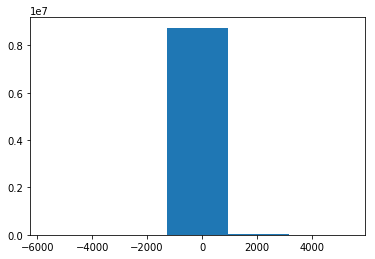

In [111]:
plt.hist(trip_duration_df.duration, bins=5) #there is a value which is much more higher than the rest (outlier)

Lets check the most important information about this data

In [73]:
trip_duration_df.duration.describe()

count    8.759874e+06
mean     1.517210e+01
std      6.034019e+01
min     -5.712000e+03
25%      6.000000e+00
50%      1.000000e+01
75%      1.600000e+01
max      5.382000e+03
Name: duration, dtype: float64

We wanna ignore outliers. Additionally, we can observe that some trips lasted less than 0 minutes. It is impossible (probably there was a mistake). It is reasonable to ignore values less than 0 minutes. 

We can use an argument **range** in plt.hist() to set the lower and upper range of the bins. Lower and upper outliers are ignored.

How to choose the upper range ? Lets check our data!

In [109]:
between_500_1000_min = trip_duration_df.duration[trip_duration_df.duration.between(500, 1000)].count()
more_than_1000 = trip_duration_df.duration[trip_duration_df.duration > 1000].count()
more_than_100 = trip_duration_df.duration[trip_duration_df.duration > 100].count()
print("trips between 500 and 1000 minutes: {0} which is {1:.6f} percentage of all".format(between_500_1000_min, between_500_1000_min/8759874))
print("trips lasted more than 1000 minutes: {0} which is {1:.6f} percentage of all".format(more_than_1000, more_than_1000/8759874))
print("trips lasted more than 100 minutes: {0} which is {1:.6f} percentage of all".format(more_than_100, more_than_100/8759874))

trips between 500 and 1000 minutes: 737 which is 0.000084 percentage of all
trips lasted more than 1000 minutes: 15528 which is 0.001773 percentage of all
trips lasted more than 100 minutes: 18582 which is 0.002121 percentage of all


The percentage of trips which lasted more than 100 minutes is very small - about 0.002 %.


##### It seems rational to conduct analysis for trips under 100 minutes, that represent a significant amount of data (99.998 %).

Every bin is for one minute.

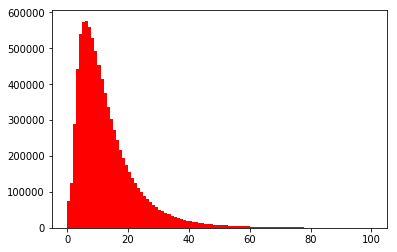

In [120]:
h1 = plt.hist(trip_duration_df.duration, bins=100, range=(0, 100), density=False, color="red")
# thanks to argument density=True we are getting the probability density
# ?? MAybe a normal histogram is better?

In [113]:
trip_duration_df.duration[trip_duration_df.duration.between(0, 100)].describe()

count    8.741290e+06
mean     1.258850e+01
std      1.019025e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.600000e+01
max      1.000000e+02
Name: duration, dtype: float64

In [119]:
# describe the histogram above better!

We found something interesting in our data. Look at histogram below with a higher number of bins. One bin has a range of 0.5 min.

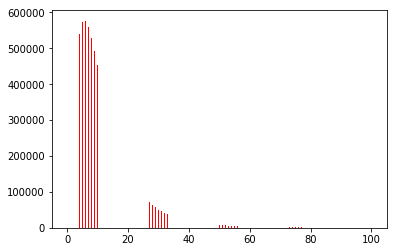

In [123]:
h2 = plt.hist(trip_duration_df.duration, bins=1000, range=(0, 100), density=False, color="red", stacked=True)

We can observe 4 different types of trips <??> but why? #TODO check it